In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import plot_ellipse, moca, smooth, tilt_distance_LI, robust_smooth, normalize_matrix, calc_ow
from utils import project_sadcp_to_transect, translate_moca_results


#### SADCP Data

In [2]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=['u_' + str(z) for z in z_sadcp]).T
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=['v_' + str(z) for z in z_sadcp]).T
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

df_sadcp = pd.DataFrame({'Time': tim_sadcp, 'Lon': lon_sadcp, 'Lat': lat_sadcp})
df_sadcp = pd.concat([df_sadcp, u_sadcp, v_sadcp], axis=1)

df_sadcp = df_sadcp[df_sadcp['Lat'] <= -37]
df_sadcp = df_sadcp.reset_index().drop(columns=['index'])

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
df_sadcp['x'] = (df_sadcp.Lon - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
df_sadcp['y'] = (df_sadcp.Lat - phi_mean) * 111000

df_sadcp


,Time,Lon,Lat,u_27,u_37,u_47,u_57,u_67,u_77,u_87,...,v_737,v_747,v_757,v_767,v_777,v_787,v_797,v_807,x,y
0,2023-10-17 10:27:31.000004,154.357059,-37.005208,NaN,0.534412,0.569007,0.549270,0.465635,0.374654,0.323217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4997.725425,99321.875000
1,2023-10-17 10:42:30.333327,154.360804,-37.038123,NaN,0.533096,0.555601,0.561888,0.484809,0.402146,0.357385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5325.695073,95668.330556
2,2023-10-17 10:57:30.666685,154.364625,-37.071899,NaN,0.431565,0.456292,0.483472,0.458337,0.434674,0.398060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5660.396047,91919.202778
3,2023-10-17 11:12:30.333340,154.368274,-37.101418,NaN,0.368063,0.378524,0.410269,0.398222,0.362505,0.358032,...,0.043708,0.042462,NaN,NaN,NaN,NaN,NaN,NaN,5980.012364,88642.647222
4,2023-10-17 11:27:30.666659,154.372221,-37.104340,NaN,0.357789,0.368125,0.399916,0.385093,0.353109,0.356878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6325.742980,88318.280556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,2023-10-21 21:27:30.333314,154.179344,-37.150309,NaN,0.246921,0.241454,0.244281,0.212926,0.202732,0.233854,...,0.080013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10568.100129,83215.672222
429,2023-10-21 21:42:30.666672,154.179347,-37.119931,NaN,0.222701,0.196322,0.206364,0.223129,0.236286,0.265476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10567.775728,86587.708333
430,2023-10-21 21:57:30.333327,154.179332,-37.088953,NaN,0.214721,0.206698,0.228885,0.243320,0.250907,0.249915,...,0.085535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10569.073333,90026.241667
431,2023-10-21 22:12:30.333314,154.179352,-37.058304,NaN,0.219740,0.226015,0.243559,0.245731,0.227310,0.231003,...,0.077085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10567.370226,93428.288889


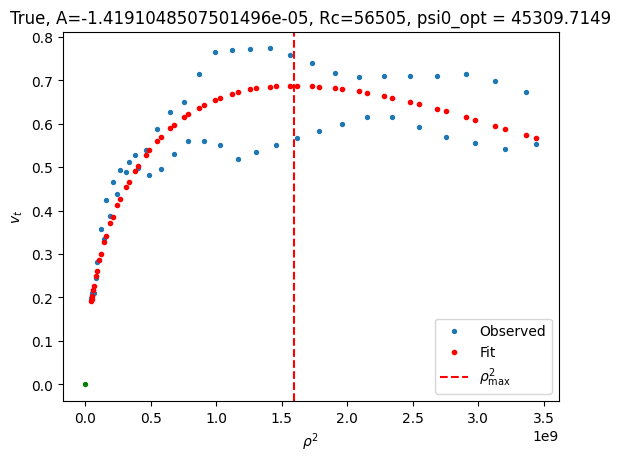

(-50.0, 50.0)

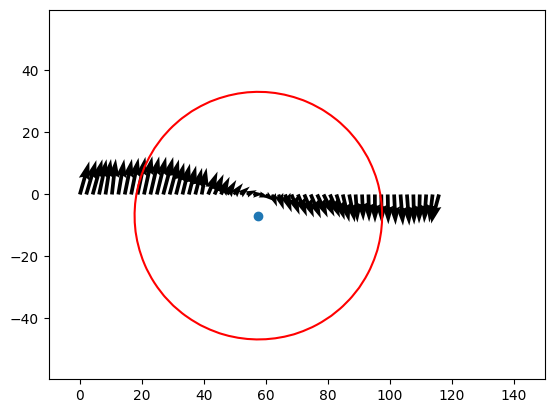

In [3]:
t_transect= pd.Timestamp('2023-10-20 12:00:00')
days = .3

mask = (df_sadcp.Time>=t_transect-pd.Timedelta(days=days))&(df_sadcp.Time<=t_transect+pd.Timedelta(days=days))
df_transect = df_sadcp[mask]

df_proj_trans, m = project_sadcp_to_transect(df_transect.x, df_transect.y, df_transect.u_37, df_transect.v_37)
l0, r0, w, Q, Rc, psi0, A = moca(df_proj_trans.l, df_proj_trans.V_T, df_proj_trans.V_N, plot_flag=True)
xc, yc = translate_moca_results(df_proj_trans.iloc[0].x, df_proj_trans.iloc[0].y, m, l0, r0)

x = np.linspace(-150000, 150000, 101)
y = np.linspace(-150000, 150000, 101)
X, Y = np.meshgrid(x, y, indexing='ij')

plt.quiver(df_proj_trans.l/1e3, [0]*len(df_proj_trans.l), df_proj_trans.V_T, df_proj_trans.V_N)
plt.scatter(l0/1e3, r0/1e3)
dx_ell, dy_ell = X/1e3 - l0/1e3, Y/1e3 - r0/1e3
rho2_ell = Q[0,0]*dx_ell**2 + 2*Q[1,0]*dx_ell*dy_ell + Q[1,1]*dy_ell**2
plt.contour(X/1e3, Y/1e3, rho2_ell, levels=[(Rc/1e3)**2/2],
            colors='r')
plt.axis('equal'); plt.xlim(-10, 150); plt.ylim(-50, 50)


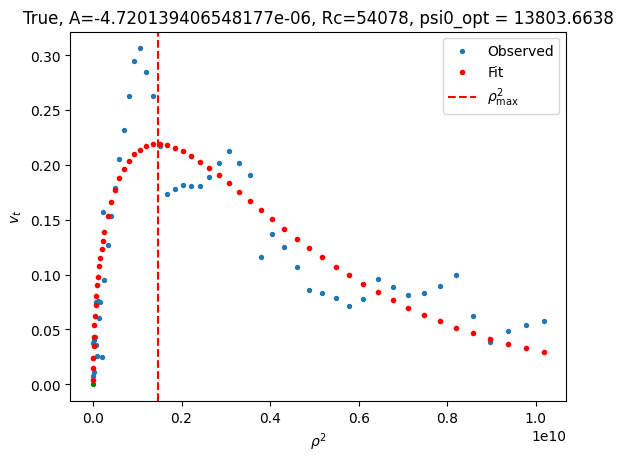

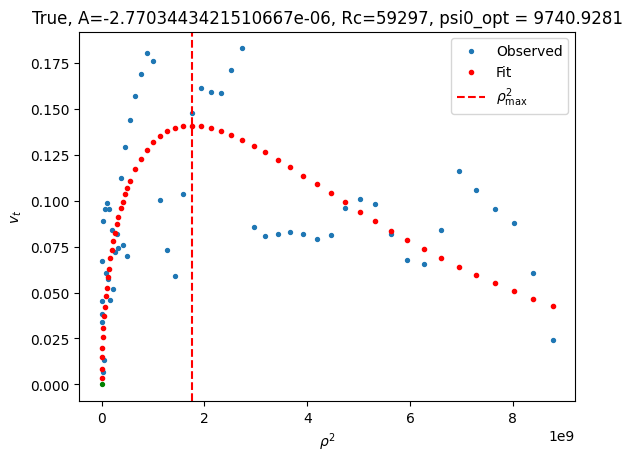

In [4]:
u_cols = [col for col in df_transect.columns if 'u' in col]
v_cols = [col for col in df_transect.columns if 'v' in col]

df_res = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'A', 'Depth'])
for k, (u_col, v_col) in enumerate(zip(u_cols, v_cols)):
    depth = int(u_col[2:])
    if depth < 300:
        df_proj_trans, m = project_sadcp_to_transect(df_transect.x, df_transect.y,
                                                     df_transect[u_col], df_transect[u_col])
        if sum(~np.isnan(df_transect[u_col])) > 10:
            l0, r0, w, Q, Rc, psi0, A = moca(df_proj_trans.l, df_proj_trans.V_T,
                                             df_proj_trans.V_N, plot_flag=True if k%10==0 else False,
                                             Rc_max=150000)
            xc, yc = translate_moca_results(df_proj_trans.iloc[0].x, df_proj_trans.iloc[0].y, m, l0, r0)
            df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q,
                                       'Rc': Rc, 'psi0': psi0, 'A': A, 'Depth': depth}
        

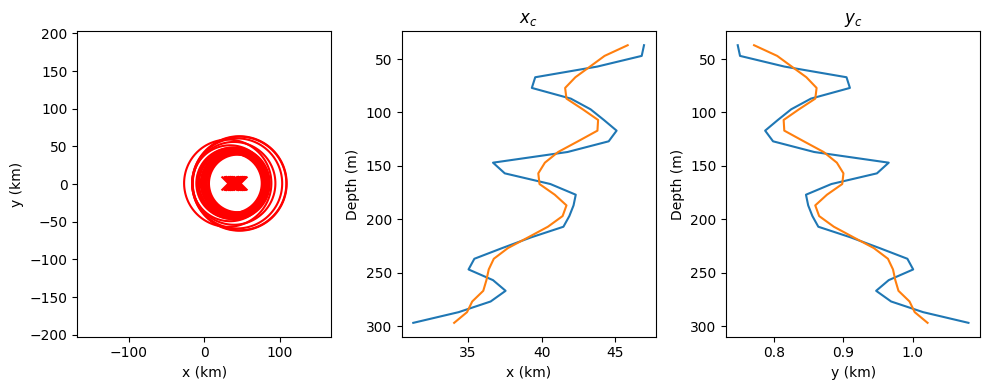

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(10,4))
for k in range(len(df_res)):
    data = df_res.iloc[k]
    axs[0].scatter(data.xc/1e3, data.yc/1e3, marker='x', s=100, color='r', zorder=3)
    dx_ell, dy_ell = X/1e3 - data.xc/1e3, Y/1e3 - data.yc/1e3
    rho2_ell = data.Q[0,0]*dx_ell**2 + 2*data.Q[1,0]*dx_ell*dy_ell + data.Q[1,1]*dy_ell**2
    axs[0].contour(X/1e3, Y/1e3, rho2_ell, levels=[(data.Rc/1e3)**2/2],
                colors='r')
axs[0].axis('equal'); axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')

wdw = 5
df_res['sxc'] = smooth(df_res.xc, df_res.Depth, window=wdw, num=len(df_res)) 
df_res['syc'] = smooth(df_res.yc, df_res.Depth, window=wdw, num=len(df_res)) 
axs[1].plot(df_res.xc/1e3, df_res.Depth)
axs[1].plot(df_res.sxc/1e3, df_res.Depth)
axs[1].invert_yaxis()
axs[1].set_xlabel('x (km)'); axs[1].set_ylabel('Depth (m)'); axs[1].set_title(r'$x_c$')
axs[2].plot(df_res.yc/1e3, df_res.Depth)
axs[2].plot(df_res.syc/1e3, df_res.Depth)
axs[2].invert_yaxis()
axs[2].set_xlabel('y (km)'); axs[2].set_ylabel('Depth (m)'); axs[2].set_title(r'$y_c$')
plt.tight_layout()


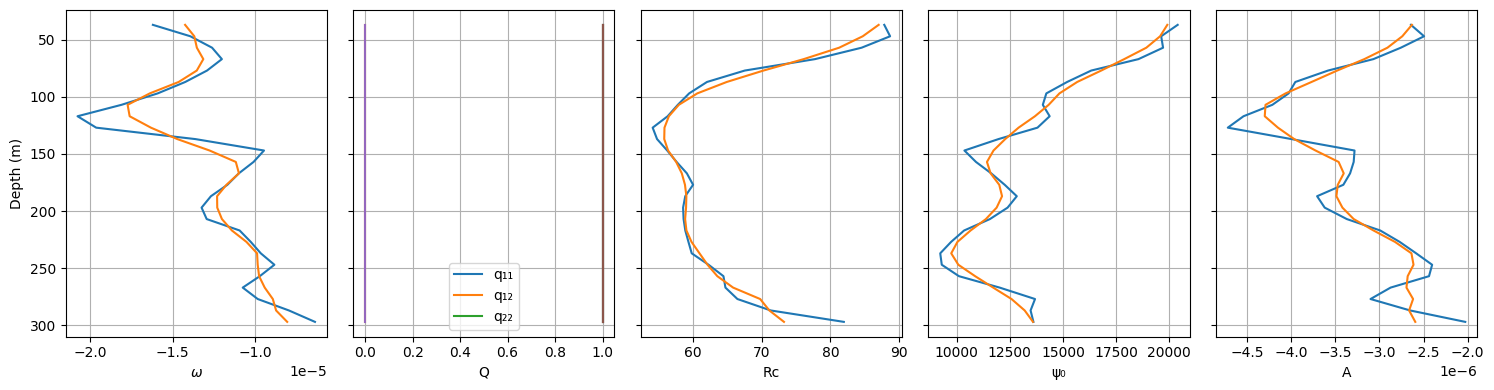

In [6]:
wdw = 5
df_res['sw'] = smooth(df_res.w, df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sq11'] = smooth(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sq12'] = smooth(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sq22'] = smooth(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sRc'] = smooth(df_res.Rc, df_res.Depth, window=wdw, num=len(df_res)) 
df_res['spsi0'] = smooth(df_res.psi0, df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sA'] = smooth(df_res.A, df_res.Depth, window=wdw, num=len(df_res)) 

fig, axs = plt.subplots(1, 5, figsize=(15,4), sharey=True)

axs[0].plot(df_res.w, df_res.Depth)
axs[0].plot(df_res.sw, df_res.Depth)
axs[0].set_xlabel(r'$\omega$')

axs[1].plot(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Depth, label='q₁₁')
axs[1].plot(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Depth, label='q₁₂')
axs[1].plot(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Depth, label='q₂₂')
axs[1].plot(df_res.sq11, df_res.Depth)
axs[1].plot(df_res.sq12, df_res.Depth)
axs[1].plot(df_res.sq22, df_res.Depth)
axs[1].set_xlabel('Q')
axs[1].legend()

axs[2].plot(df_res.Rc/1000, df_res.Depth)
axs[2].plot(df_res.sRc/1000, df_res.Depth)
axs[2].set_xlabel('Rc')

axs[3].plot(df_res.psi0, df_res.Depth)
axs[3].plot(df_res.spsi0, df_res.Depth)
axs[3].set_xlabel('ψ₀')

axs[4].plot(df_res.A, df_res.Depth)
axs[4].plot(df_res.sA, df_res.Depth)
axs[4].set_xlabel('A')

for ax in axs:
    ax.grid(True)
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()

plt.tight_layout()


In [7]:
U = np.zeros((X.shape[0], X.shape[1], len(df_res)))
V = np.zeros((X.shape[0], X.shape[1], len(df_res)))
OW = np.zeros((X.shape[0], X.shape[1], len(df_res)))

for k in range(len(df_res)):
    data = df_res.iloc[k]
    dx, dy = X - data.sxc, Y - data.syc
    rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2

    U[:,:,k] = - data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy )
    V[:,:,k] =   data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy ) 

    OW[:,:,k] = calc_ow(U[:,:,k].T, V[:,:,k].T, x[1]-x[0], y[1]-y[0])
OW = normalize_matrix(OW)


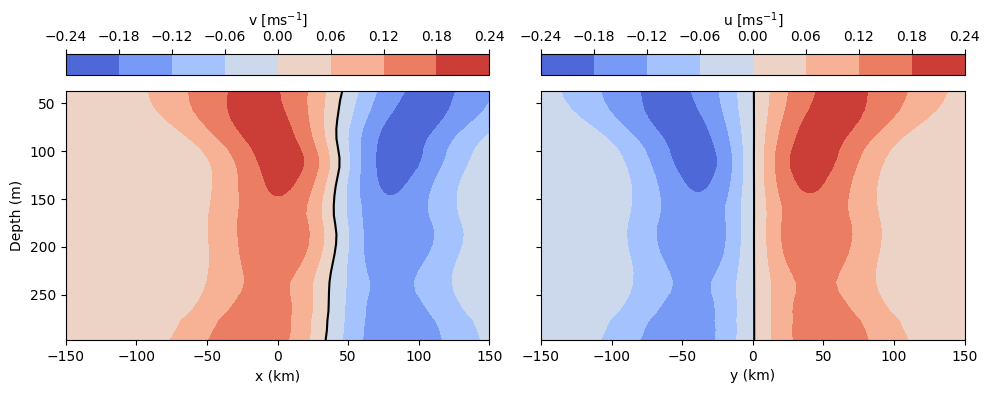

In [8]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

xc_surf, yc_surf = df_res.iloc[0].xc, df_res.iloc[0].yc
ic_surf = np.argmin(np.abs(x - xc_surf))
jc_surf = np.argmin(np.abs(y - yc_surf))

c1 = axs[0].contourf(x/1e3, df_res.Depth, V[:, jc_surf, :].T, cmap='coolwarm')
axs[0].plot(df_res.sxc/1e3, df_res.Depth, color='k')
c2 = axs[1].contourf(y/1e3, df_res.Depth, U[ic_surf, :, :].T , cmap='coolwarm')
axs[1].plot(df_res.syc/1e3, df_res.Depth, color='k')
axs[0].invert_yaxis()

fig.colorbar(c1, ax=axs[0], orientation='horizontal', location='top', label=r'v [ms$^{-1}$]')
fig.colorbar(c2, ax=axs[1], orientation='horizontal', location='top', label=r'u [ms$^{-1}$]')

axs[0].set_ylabel('Depth (m)'); axs[0].set_xlabel('x (km)'); axs[1].set_xlabel('y (km)');
plt.tight_layout()
plt.show()
